In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
#from ggplot import *
% matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

UsageError: Line magic function `%` not found.


# Define Mortgage Details: 

In [40]:
# Calculates monthly payment given number of months(n), loan amount(L), and the monthly interest rate (APY/12)
def calculate_montly_payment(n,L,monthly_interest):
    I = monthly_interest
    numerator = L*(1 + I)**n
    denomenator = -1*(1 - (1 + I)**n) / I
    return (numerator/denomenator)

In [63]:
# Mortgage
time = 30 # number of years for mortgage
interest = .06 # APY interest rate
price = 1000000 # dollars
down_payment = .2 # percent/100
yearly_house_appreciation = .08 # percent appreciation of house value

# Taxes
marginal_tax_rate = .32 
expected_deduction = 13850 # expected standard deduction for current year
expected_deduction_yearly_increase = 200 # expected increase in standard deduction each year
#expected_deduction = 0 # expected standard deduction for current year
#expected_deduction_yearly_increase = 0 # expected increase in standard deduction each year
property_tax = .01 # percent of house value payed as yearly property tax
long_term_capital_gains = .15

# Extra Costs
yearly_maintenance = .003 # percent of house value set aside yearly for repairs and maintenance
hoa_fee = 600 # montly hoa fee
hoa_yearly_increase = .01 # yearly percent increase in hoa fee
homeowner_insurance = 120 # monthly payment for insurance
homeowner_yearly_increase = .01 # yearly percent increase in insurance
closing_buy = .025 # percent of house value for closing cost when buying
closing_sell = .025 # percent of house value for closing cost when selling

#Rental Income
monthly_rent = 3600 # expected monthly rent for current year
rent_yearly_increase = .03 # yearly percent increase in rent
percent_vacancy = 1.0/12.0 # percent of the year with vacancy
rent_percent = 0 #percent of monthly rent as income, 0 means not renting, 1 means rental property

# Oportunity costs
investment_return = .08 #average yearly return
opportunity_rent = monthly_rent * (1 - rent_percent)

In [64]:
# For calculations: do not edit
n = time * 12 #number of months for the loan
L = price * (1.0 - down_payment) # loan amount
monthly_interest = interest/12.0 # monthly interest rate as a percent/100
p = calculate_montly_payment(n,L,monthly_interest) # monthly payment
print('Monthly Payment = %.2f'%p)

Monthly Payment = 4796.40


Key Assumptions:  
1. No capital gains when you sell your house (google for details)
2. House Value, HOA, Maintenance, Insurance, and Rent all increase/decrease by the same amount each year. Not a problem for long-term if good estimates.
3. You stick with one rental strategy.
4. Fixed Rate
5. No PMI
6. All gains on stocks are long term capital gains

# Calculate Cumulative Equity and Interest per month: 

In [65]:
mortgage = pd.DataFrame()
loan = L
month_list = range(1,n+1)
for month in month_list: # simulate monthly payment
    mortgage_month = pd.DataFrame()
    mortgage_month['Month'] = [month]
    mortgage_month['Loan_Before_Payment'] = loan
    loan = loan * (1+ monthly_interest) - p
    mortgage_month['Loan_After_Payment'] = loan
    mortgage_month['Equity_Gain'] = mortgage_month['Loan_Before_Payment'] - mortgage_month['Loan_After_Payment']
    mortgage = pd.concat([mortgage,mortgage_month])
mortgage['Interest_Paid'] = p - mortgage['Equity_Gain']
mortgage['Tax_Savings'] = mortgage['Interest_Paid'] * marginal_tax_rate
mortgage['Cumulative_Tax_Savings'] = mortgage['Tax_Savings'].cumsum()
mortgage['Year'] = np.ceil(mortgage['Month']/12.0)
mortgage['Cumulative_Equity_Gain'] = mortgage['Equity_Gain'].cumsum()
mortgage['Cumulative_Interest_Paid'] = mortgage['Interest_Paid'].cumsum()
mortgage['Total_Equity_With_Appreciation'] = (mortgage['Cumulative_Equity_Gain'] + down_payment * price) * (1 + yearly_house_appreciation)**mortgage['Year']
mortgage.reset_index(inplace = True)

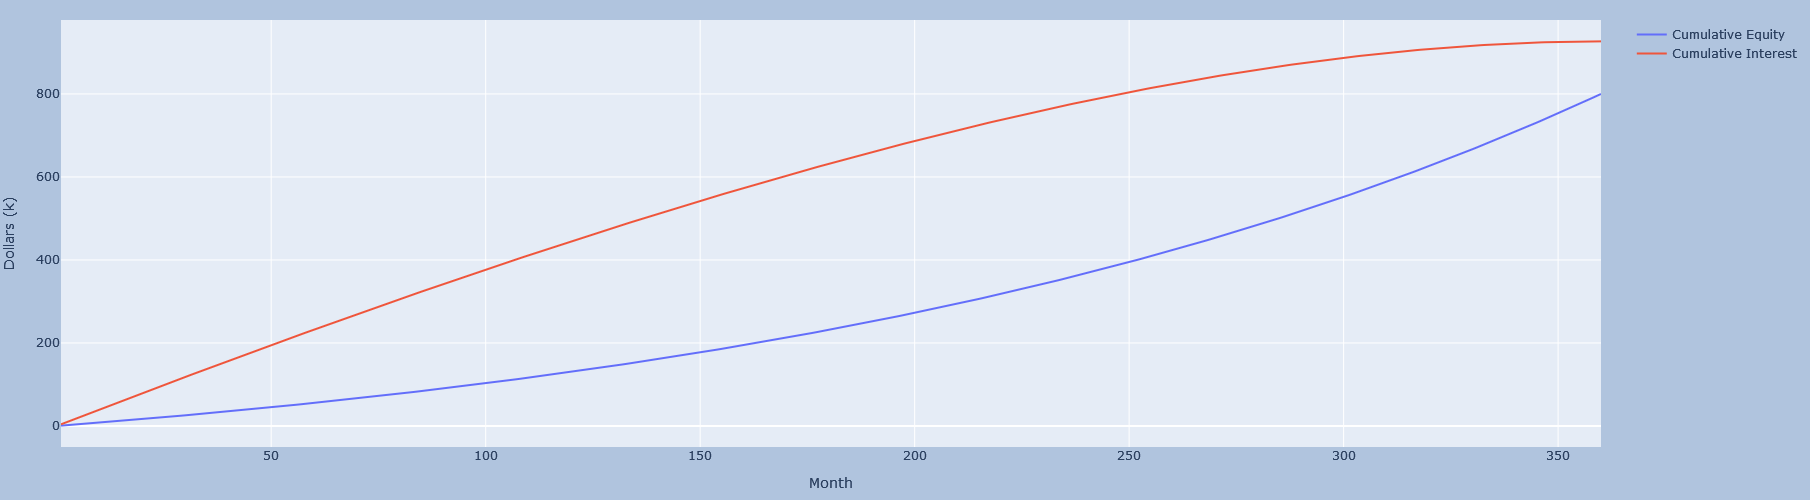

In [66]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=mortgage['Month'], y=mortgage['Cumulative_Equity_Gain']/1000,
                    mode='lines',
                    name='Cumulative Equity'))
fig.add_trace(go.Scatter(x=mortgage['Month'], y=mortgage['Cumulative_Interest_Paid']/1000,
                    mode='lines',
                    name='Cumulative Interest'))

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
    width = 1000,
    height = 500,
    xaxis_title="Month",
    yaxis_title="Dollars (k)",
)

fig.show()

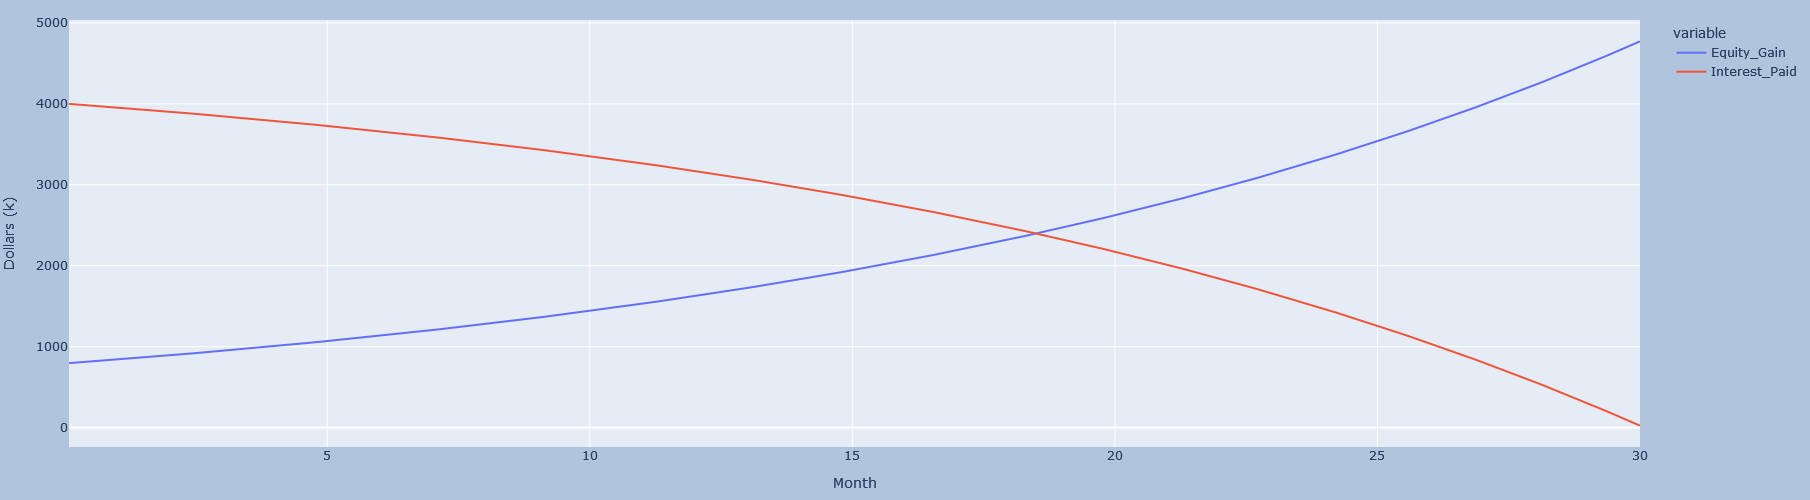

In [67]:
plot_data_monthly = pd.melt(mortgage[['Month','Equity_Gain','Interest_Paid']], id_vars = ['Month'], value_vars = ['Equity_Gain','Interest_Paid'])
plot_data_monthly['Year'] = plot_data_monthly['Month'] / 12
fig = px.line(plot_data_monthly, x="Year", y="value", color='variable')
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
    width = 1000,
    height = 500,
    xaxis_title="Month",
    yaxis_title="Dollars (k)",
)

fig.show()

# Yearly Info:

In [68]:
yearly_mortgage = mortgage[mortgage.Month%12 == 0] # Gives end of the year
yearly_mortgage = yearly_mortgage[['Year','Cumulative_Interest_Paid','Total_Equity_With_Appreciation','Cumulative_Tax_Savings']]

# House Appreciation
yearly_mortgage['House_Value'] = price * (1 + yearly_house_appreciation)**yearly_mortgage['Year']

# Taxes
yearly_mortgage['Property_Tax'] = property_tax * yearly_mortgage['House_Value']
yearly_mortgage['Cumulative_Property_Tax'] = yearly_mortgage['Property_Tax'].cumsum()
yearly_mortgage['Tax_Savings'] = yearly_mortgage['Cumulative_Tax_Savings'] 
yearly_mortgage['Tax_Savings'].iloc[1:len(yearly_mortgage)] = np.diff(yearly_mortgage['Cumulative_Tax_Savings']) #so far only from interest
yearly_mortgage['Tax_Savings'] += marginal_tax_rate * yearly_mortgage['Property_Tax'] # property tax also deductable
yearly_mortgage['Expected_Tax_Savings'] = (expected_deduction + expected_deduction_yearly_increase * mortgage['Year']) * (marginal_tax_rate) # Tax savings from standard dedecution
yearly_mortgage['Effective_Tax_Savings'] = yearly_mortgage['Tax_Savings'] - yearly_mortgage['Expected_Tax_Savings'] # Only count if savings above what you would get from standard deduction
yearly_mortgage['Effective_Tax_Savings'] = yearly_mortgage['Effective_Tax_Savings'].apply(lambda x: x if x > 0 else 0)
yearly_mortgage['Cumulative_Tax_Savings'] = yearly_mortgage['Effective_Tax_Savings'].cumsum()

# Total Costs
yearly_mortgage['HOA'] = 12 * hoa_fee * ((1 + hoa_yearly_increase) ** yearly_mortgage['Year'])
yearly_mortgage['Cumulative_HOA'] = yearly_mortgage['HOA'].cumsum()
yearly_mortgage['Homeowner_Insurance'] = 12 *homeowner_insurance * ((1 + homeowner_yearly_increase) ** yearly_mortgage['Year'])
yearly_mortgage['Cumulative_Homeowner_Insurance'] = yearly_mortgage['Homeowner_Insurance'].cumsum()
yearly_mortgage['Maintenance'] = yearly_maintenance * yearly_mortgage['House_Value']
yearly_mortgage['Cumulative_Maintenance'] = yearly_mortgage['Maintenance'].cumsum()
yearly_mortgage['Total_Cost'] = yearly_mortgage['Cumulative_Property_Tax'] \
+ yearly_mortgage['Cumulative_Interest_Paid']\
+ yearly_mortgage['Cumulative_HOA']\
+ yearly_mortgage['Cumulative_Homeowner_Insurance']\
+ yearly_mortgage['Cumulative_Maintenance']\
+ price * closing_buy\
+ yearly_mortgage['House_Value'] * closing_sell\


# Rental income
yearly_mortgage['Rent_Income'] = ((1-marginal_tax_rate) * (1 - percent_vacancy) * 12 * monthly_rent * rent_percent ) * ((1 + rent_yearly_increase) ** yearly_mortgage['Year']) # taxed as income
yearly_mortgage['Cumulative_Rent_Income'] = yearly_mortgage['Rent_Income'].cumsum()

# Summary
yearly_mortgage['Effective_Cost'] = yearly_mortgage['Total_Cost'] - yearly_mortgage['Cumulative_Rent_Income'] - yearly_mortgage['Cumulative_Tax_Savings']
yearly_mortgage['House_Net_Value'] = yearly_mortgage['Total_Equity_With_Appreciation'] - yearly_mortgage['Effective_Cost']

#Opportunity Cost
#yearly_mortgage['Effective_Yearly_Cost'] = yearly_mortgage['Effective_Cost'] - price * closing_buy - yearly_mortgage['House_Value'] * closing_sell #these are the recurring costs that could otherwise be invested
#yearly_mortgage['Effective_Yearly_Cost'].iloc[1:len(yearly_mortgage)] = np.diff(yearly_mortgage['Effective_Yearly_Cost'])

yearly_mortgage['Initial_Opportunity'] = ((down_payment+closing_buy)*price) * (1 + investment_return)**(yearly_mortgage['Year']) * (1-long_term_capital_gains) # investing the downpayment and the closing cost of buying
yearly_mortgage['Yearly_Rent_Cost'] = 12 * opportunity_rent * ((1 + rent_yearly_increase) ** yearly_mortgage['Year']) # The cost of renting
if rent_percent == 1:
    yearly_mortgage['Yearly_Rent_Cost'] = 0
    

# Leftover money to invest if you choose to rent instead of buy, can be negative which means renting has opportunity cost
yearly_mortgage['Extra_Investing_Money'] = p * 12\
+ yearly_mortgage['HOA']\
+ yearly_mortgage['Property_Tax']\
+ yearly_mortgage['Homeowner_Insurance']\
+ yearly_mortgage['Maintenance']\
- yearly_mortgage['Rent_Income']\
- yearly_mortgage['Effective_Tax_Savings']\
- yearly_mortgage['Yearly_Rent_Cost']

#yearly_mortgage['Extra_Investing_Money'] = yearly_mortgage['Effective_Yearly_Cost'] - yearly_mortgage['Yearly_Rent_Cost'] # Leftover money to invest if you choose to rent instead of buy, it's fine if it is negative which means renting is costing you more


yearly_growth = np.array([])
for year in range(1,1 + time): #Take the extra investing money each year and invest it
    growth_years = yearly_mortgage[yearly_mortgage.Year <= year][['Year','Extra_Investing_Money']]
    growth_years['Years_Investing'] = np.array(growth_years.Year)[::-1] - 1 # The extra money is what you have at the end of the year, so at year 3, you would have invested the year 1 money for 2 years
    growth_years['Growth'] = growth_years['Extra_Investing_Money'] * (1 + investment_return) ** growth_years['Years_Investing']
    yearly_growth = np.append(yearly_growth,np.array([growth_years.Growth.sum()]))
    
yearly_mortgage['Total_Investment'] = yearly_growth * (1 - long_term_capital_gains)
yearly_mortgage['Rent_Net_Value'] = yearly_mortgage['Initial_Opportunity'] + yearly_mortgage['Total_Investment']
yearly_mortgage['Opportunity_Cost'] = yearly_mortgage['Rent_Net_Value'] - yearly_mortgage['House_Net_Value']

display_list = ['Year','Property_Tax','Effective_Tax_Savings','HOA','Homeowner_Insurance','Maintenance','Rent_Income','Rent_Net_Value','House_Net_Value']
yearly_mortgage[display_list]    

,Year,Property_Tax,Effective_Tax_Savings,HOA,Homeowner_Insurance,Maintenance,Rent_Income,Rent_Net_Value,House_Net_Value
11,1.0,10800.000000,14234.482149,7272.000000,1454.400000,3240.000000,0.0,2.249039e+05,1.183453e+05
23,2.0,11664.000000,14253.064996,7344.720000,1468.944000,3499.200000,0.0,2.611285e+05,8.962910e+04
35,3.0,12597.120000,14281.807091,7418.167200,1483.633440,3779.136000,0.0,3.001639e+05,6.431807e+04
47,4.0,13604.889600,14321.740292,7492.348872,1498.469774,4081.466880,0.0,3.422738e+05,4.294946e+04
59,5.0,14693.280768,14373.992519,7567.272361,1513.454472,4407.984230,0.0,3.877473e+05,2.614133e+04
71,6.0,15868.743229,14439.796275,7642.945084,1528.589017,4760.622969,0.0,4.369017e+05,1.460471e+04
83,7.0,17138.242688,14520.497898,7719.374535,1543.874907,5141.472806,0.0,4.900853e+05,9.157411e+03
95,8.0,18509.302103,14617.567602,7796.568281,1559.313656,5552.790631,0.0,5.476800e+05,1.073992e+04
107,9.0,19990.046271,14732.610392,7874.533963,1574.906793,5997.013881,0.0,6.101048e+05,2.043370e+04
119,10.0,21589.249973,14867.377901,7953.279303,1590.655861,6476.774992,0.0,6.778191e+05,3.948209e+04


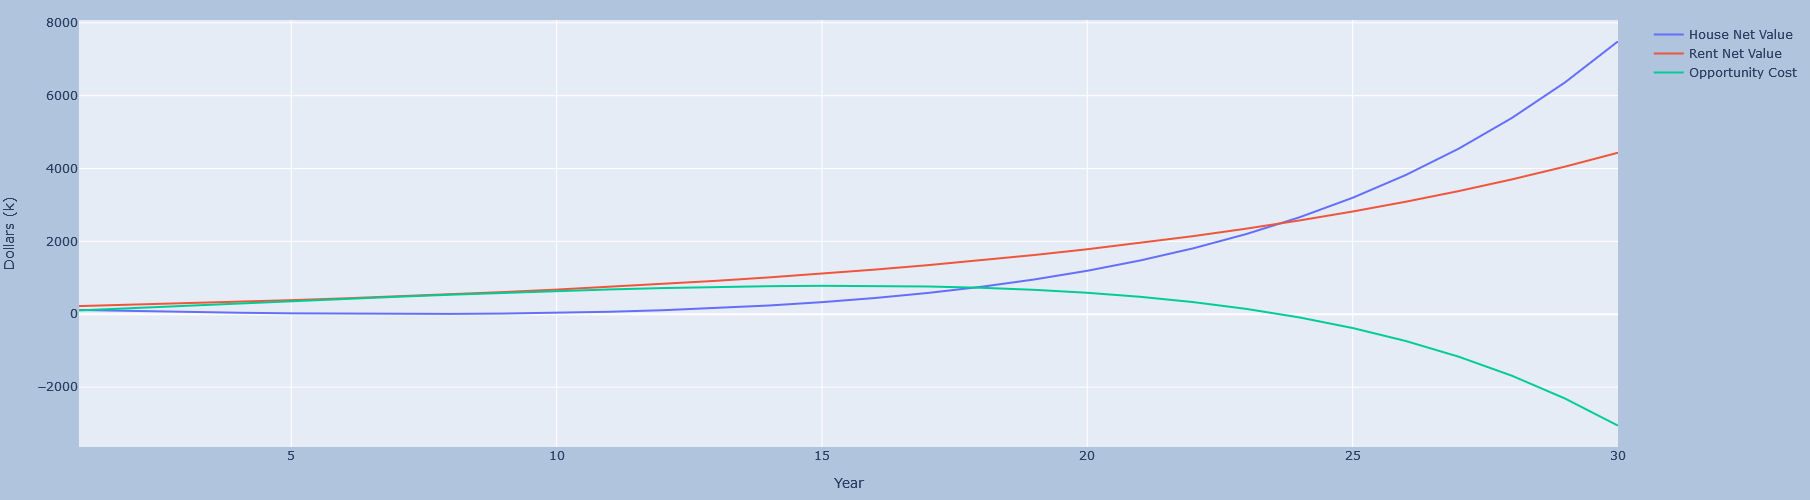

In [69]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=yearly_mortgage['Year'], y=yearly_mortgage['House_Net_Value']/1000,
                    mode='lines',
                    name='House Net Value'))
fig.add_trace(go.Scatter(x=yearly_mortgage['Year'], y=yearly_mortgage['Rent_Net_Value']/1000,
                    mode='lines',
                    name='Rent Net Value'))

fig.add_trace(go.Scatter(x=yearly_mortgage['Year'], y=yearly_mortgage['Opportunity_Cost']/1000,
                    mode='lines',
                    name='Opportunity Cost'))

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
    width = 1000,
    height = 500,
    xaxis_title="Year",
    yaxis_title="Dollars (k)",
)

fig.show()

**House_Net_Value**: This is the amount of money in your pocket after you live there for x years and sell it on year x.  
**Rent_Net_Value**: This is the amount of money you have after x years if you rent instead and invest your initial cost (downpayment and closing). You invest the lefover money you have saved from renting.